# Wing modelling example #

In this example, we demonstrate, how to build up a wing surface by starting with a list of curves. These curves are then interpolated using a B-spline suface interpolation

## Importing modules ##

Again, all low lovel geometry functions can be found in the ```tigl3.geometry``` module. For a more convenient use,
the module __```tigl3.surface_factories```__ offers functions to create surfaces. Lets use this!

In [14]:
import tigl3.curve_factories
import tigl3.surface_factories
from OCC.gp import gp_Pnt
from OCC.Display.WebGl.jupyter_renderer import JupyterRenderer
from OCC.BRepBuilderAPI import BRepBuilderAPI_MakeFace, BRepBuilderAPI_MakeEdge
import numpy as np

## Step 1: Create profile points ##

Now, we want to create 3 profiles that are the input for the profile curves. The wing should have one curve at its root, one at its outer end and one at the tip of a winglet.

In [11]:
# list of points on NACA2412 profile
px = [1.000084, 0.975825, 0.905287, 0.795069, 0.655665, 0.500588, 0.34468, 0.203313, 0.091996, 0.022051, 0.0, 0.026892, 0.098987, 0.208902, 0.346303, 0.499412, 0.653352, 0.792716, 0.90373, 0.975232, 0.999916]
py = [0.001257, 0.006231, 0.019752, 0.03826, 0.057302, 0.072381, 0.079198, 0.072947, 0.054325, 0.028152, 0.0, -0.023408, -0.037507, -0.042346, -0.039941, -0.033493, -0.0245, -0.015499, -0.008033, -0.003035, -0.001257]

points_c1 = np.array([pnt for pnt in zip(px, [0.]*len(px), py)]) * 2.
points_c2 = np.array([pnt for pnt in zip(px, [0]*len(px), py)])
points_c3 = np.array([pnt for pnt in zip(px, py, [0.]*len(px))]) * 0.2

# shift sections to their correct position
# second curve at y = 7
points_c2 += np.array([1.0, 7, 0])

# third curve at y = 7.5
points_c3[:, 1] *= -1
points_c3 += np.array([1.7, 7.8, 1.0])

## Interpolation of the airfoil with a B-spline ##

TiGL brings many algorithms, that build curves and surfaces. The core algorithms can be found in the __tigl3.geometry__ package. These algorithms depend however on the opencascade data structures. To make it more convenient, the __tigl3.curve_factories__ package offers more python functions to create curves.

The most basic function is ```tigl3.curve_factories.interpolate_points```. This takes an array of points and builds up the interpolating b-spline.

In [12]:
tigl3.curve_factories_factories.interpolate_points?

Object `tigl3.curve_factories_factories.interpolate_points` not found.


The ```interpolate_points function``` has some optional parameters as well.
 - ```degree```: Controls the polynomial degree. If degree=1, the curve will be piecewise linear.
 - ```params```: Controls, at which parameter the points will be interpolated. This array must have the same number of items as the points array!
 - ```close_continuous```: If you interpolate e.g. a fuselage section, you probably want a continous passing of the curve at the start and the end of the section. if close_continuous=True, the passing will be continous. For wings, where a discontinous trailing edge is desired, it should be False.

### Build profiles curves ###

Now, lets built the profiles curves using ```tigl3.curve_factories.interpolate_points```.

In [13]:
curve1 = tigl3.curve_factories.interpolate_points(points_c1)
curve2 = tigl3.curve_factories.interpolate_points(points_c2)
curve3 = tigl3.curve_factories.interpolate_points(points_c3)

### Visualization of the result ###

Now lets visualize the interpolated curves. We are using the pythonOCC SimpleGui to draw the curve and the points. The jupyter renderer does not yet support curves and points (only surfaces). 

We first draw all the points without updating the viewer. This would be very slow.
Then, we draw the curve.

In [17]:
# create jupyter renderer
viewer = JupyterRenderer()

# draw the points
viewer.DisplayPoints(points_c1, name='p1', size=5, color="red", update=False)
viewer.DisplayPoints(points_c2, name='p2', size=5, color="red", update=False)
viewer.DisplayPoints(points_c3, name='p3', size=5, color="red", update=False)

# get the curves as edges
curve1_edge = BRepBuilderAPI_MakeEdge(curve1).Edge()
curve2_edge = BRepBuilderAPI_MakeEdge(curve2).Edge()
curve3_edge = BRepBuilderAPI_MakeEdge(curve2).Edge()

# display the edges
viewer.DisplayShape(curve1_edge, update=False, shape_color='#2cd342', quality=0.05)
viewer.DisplayShape(curve2_edge, update=False, shape_color='#2cd342', quality=0.05)
viewer.DisplayShape(curve3_edge, update=False, shape_color='#2cd342', quality=0.05)
viewer._camera.fov=9.

viewer

Result:
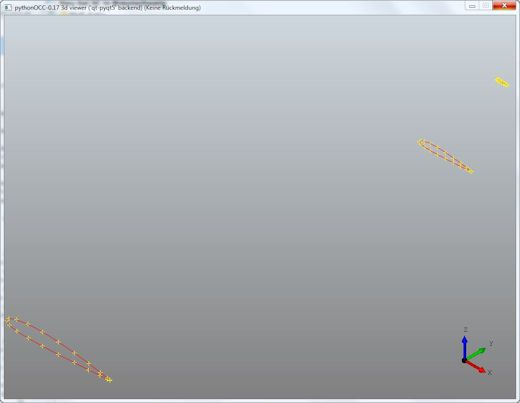

## Step 2: Create the surface ##
The final surface is created with the B-spline interpolation from the ```tigl3.surface_factories``` package.

The function tigl3.surface_factories.interpolate_curves has many more parameters that influence the resulting shape. Lets have a look:


In [18]:
tigl3.surface_factories.interpolate_curves?

Use the function to interpolate the three curves to a surface. If you want, play around with the degree and the curve parameters. Especially the second of the three parameters has a big influence. What influence do these parameters have on the final shape?

In [19]:
surface = tigl3.surface_factories.interpolate_curves([curve1, curve2, curve3])
# surface = tigl3.surface_factories.interpolate_curves([curve1, curve2, curve3], [0., 0.7, 1.])
# surface = tigl3.surface_factories.interpolate_curves([curve1, curve2, curve3], degree=1)

## Visualize the result ##

Now, lets draw our wing. How does it look like? What can be improved?

In [22]:
# draw the surface 
face = BRepBuilderAPI_MakeFace(surface, 1e-6).Face()
viewer.DisplayShape(face, shape_color='#0070a8', transparency=True, opacity=0.4, quality=0.2, update=False)

viewer

Result:
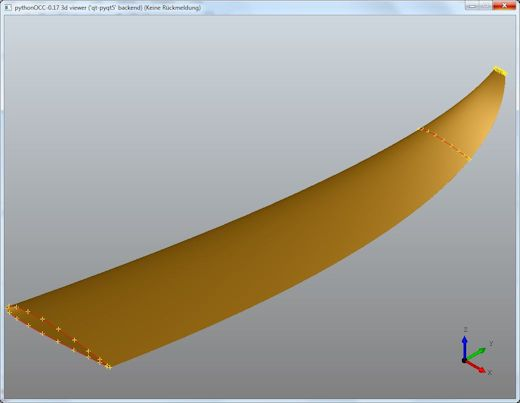

# Step 3: Add guide curves #

We still want have more control on the shape of the wing example.

One option is to simply add more profiles and tweak their shape. Another, more elegant way is to additionally use some guide curves for e.g. the leading and trailing edges.

In this example, we are tweaking the leading edge and using our curve network interpolation algorithm that is based on gordon surfaces. Gordon surfaces are generalization of coons patches. Where coons patches can only interpolate two profiles and two guides at a time, gordon surfaces interpolate all curves at once globally. The benefit of gordon surfaces are better / smoother resulting surfaces.

If you want to read about them im more detail, have a look into _"The NURBS Book, 2nd Edition"_, Chapter 10.5 (Interpolation of a Bidirectional Curve Network): https://www.springer.com/de/book/9783642973857

### First, lets create a copy of the airfoil curves ###

Lets shift the airfoil points by 3 along the x-axis.

In [23]:
points_c1[:,0]+=3
points_c2[:,0]+=3
points_c3[:,0]+=3

# interpolate the three point sets to new profile curves
profile1 = tigl3.curve_factories.interpolate_points(points_c1)
profile2 = tigl3.curve_factories.interpolate_points(points_c2)
profile3 = tigl3.curve_factories.interpolate_points(points_c3)

### Create guide curve points ###

Now, lets define some points on the guide curves. __Important: profiles and guides must intersect each other!!!__

Therefore, we explicitly add points from the profiles to the guides curves.

In [24]:
# upper trailing edge points
te_up_points = np.array([points_c1[0,:], points_c2[0,:], points_c3[0,:]])

# leading edge points. 
le_points = np.array([
    points_c1[10,:],    # First profile LE

    [3.35, 2., -0.1],# Additional point to control LE shape
    [3.7, 5., -0.2], # Additional point to control LE shape
    
    points_c2[10,:],   # Second profile LE
    points_c3[10,:], # Third profile LE
])


# lower trailing edge points
te_lo_points = np.array([points_c1[-1,:], points_c2[-1,:], points_c3[-1,:]])


Next, we will interpolate the guide curve points to obtain the leading edge, upper trailing edge and the lower trailing edge. Lets define also the parameters of the points to control the shape of the guide curve This is optional, but can improve the result 

In [25]:
te_up = tigl3.curve_factories.interpolate_points(te_up_points, [0, 0.65, 1.])
le = tigl3.curve_factories.interpolate_points(le_points, [0., 0.25, 0.55, 0.8, 1.0])
te_lo = tigl3.curve_factories.interpolate_points(te_lo_points, [0, 0.65, 1.])

### Check: Draw the guide curves ###

Now lets draw the curves. You can still tweak the leading edge, if you want.

In [26]:
# get the curves as edges
profile1_edge = BRepBuilderAPI_MakeEdge(profile1).Edge()
profile2_edge = BRepBuilderAPI_MakeEdge(profile2).Edge()
profile3_edge = BRepBuilderAPI_MakeEdge(profile3).Edge()

te_up_edge = BRepBuilderAPI_MakeEdge(te_up).Edge()
le_edge = BRepBuilderAPI_MakeEdge(le).Edge()
te_lo_edge = BRepBuilderAPI_MakeEdge(te_lo).Edge()

# display the edges
viewer.DisplayShape(profile1_edge, update=False, shape_color='#2cd342', quality=0.05)
viewer.DisplayShape(profile2_edge, update=False, shape_color='#2cd342', quality=0.05)
viewer.DisplayShape(profile3_edge, update=False, shape_color='#2cd342', quality=0.05)

viewer.DisplayShape(te_up_edge, update=False, shape_color='#2cd342', quality=0.05)
viewer.DisplayShape(le_edge, update=False, shape_color='#2cd342', quality=0.05)
viewer.DisplayShape(te_lo_edge, update=False, shape_color='#2cd342', quality=0.05)
viewer._camera.fov=9.

# also draw the guide curve points
viewer.DisplayPoints(te_up_points, name='p1', size=5, color="red", update=False)
viewer.DisplayPoints(le_points, name='p2', size=5, color="red", update=False)
viewer.DisplayPoints(te_lo_points, name='p3', size=5, color="red", update=False)
    
viewer

Result:
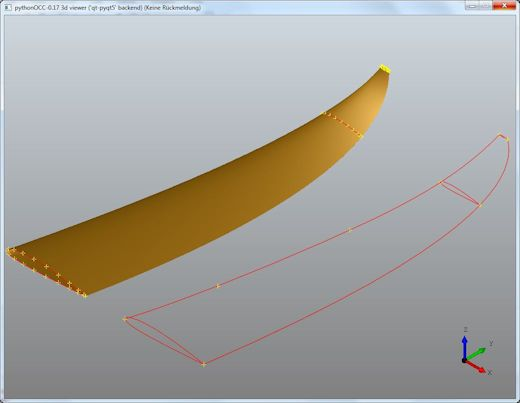

### Create the gordon surface ###
The final surface is created with the Gordon surface interpolation from the ```tigl3.surface_factories``` package.

Gordon surfaces are surfaces, that passes through a network of curves. Since we just created this network with 3 profiles and 3 guides, we can pass those to the algorithm.

In [27]:
surface = tigl3.surface_factories.interpolate_curve_network([profile1, profile2, profile3],
                                                            [te_up, le, te_lo])

### Visualize the result ###

Now, lets draw our wing. How does it look like? What can be improved?

In [28]:
face_gordon = BRepBuilderAPI_MakeFace(surface, 1e-6).Face()
viewer.DisplayShape(face_gordon, shape_color='#0070a8', transparency=True, opacity=0.4, quality=0.2, update=False)
    
# match content to screen and start the event loop
viewer

Result:
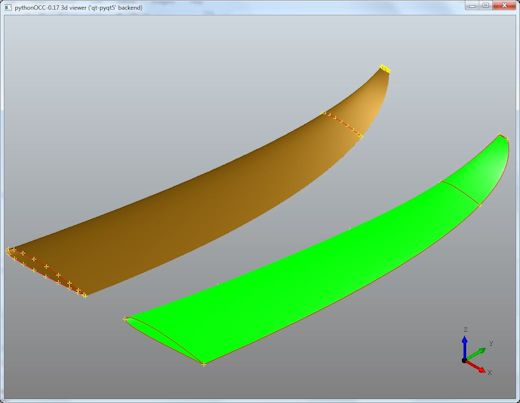